In [85]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import json
import numpy as np
from skimage.feature import hog
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import SGDClassifier

# Setting
### Package Requirement
- You can run "pip install -r requirements.txt" to install all packages required for the traditional methods
### Images Directory Address
- Put all train image in a directory, and input the directory address to the "train_img_directory" below.
- Put all test image in a directory, and input the directory address to the "test_img_directory" below.
### Annotation File Path
- We also need a train annotation path and test annotation path, also set them below
### Visualization Directory
- In the end of object detection, we need a directory to store our object detection images. Each image will use red pen to draw the object detected boundary and store them into the directory you set here. If there is no directory in the target path, it will create one to store.
- In the end of classification, we will store all labels in a directory also.
### Traditional Method Current Path
- When our group test our images using traditional method, we put all train images in the "train" directory, all test images in the "valid" directory, and also our annotation file path is "./train_annotations" and "./valid_annotations"
- Our current visualization directory is "./predicted_boundary"
- If you run the code and put these images or annotation file in a different locations, make sure to change the address below. Otherwise, we will have errors.

In [86]:
train_img_directory = "./train"
train_image_annotation_path = "./train_annotations"
test_img_directory = "./valid"
test_image_annotation_path = "./valid_annotations"
visualization_object_detection_directory = "./visualization/predicted_object_boundary"
visualization_object_classification_directory = "./visualization/predicted_classification"

In [87]:
def img_path_generator(dir, num):
    train_img_path = dir + "/" + "image_id_" + "%03d" % (num,) + ".jpg"
    if os.path.exists(train_img_path):
        return train_img_path
    return None

# Preprocess Functions
- Below is the Helper Functions used in the preprocessing process.

# Cut White Edges Preprocessing
### What are the white edges I mentioned here? How they come into the picture?
- The train images and test images provided seem to all have the same size(640 * 640 pixels). However, it is not actually true; the true images have different size, and the images provider just resize them and force to fit each image in a 640 * 640 white board. Therefore, most images have two white edges at the horizontal sides or vertical sides.
### Why we need to cut off these white edges?
- These white edges are totally irrelevant to our object detection and classification work. Since later on, we will use HOG feature extraction method to feed our traditional model. Therefore, the feature extraction algorithm may treat these white edges as an important feature. If we don't cut these white edge, our classification accuracy will decrease 10 percent, and the object detection result (IoU) will also decrease 1 percent.
### How do we cut off these white edges?
- We develop our own methods to cut these white edges. To be more specific, we use Binary Search to find the boundary of true image within the original 640 * 640 image. The process involves iteratively searching for the first non-white pixel from both the left and right sides of the image along the horizontal axis and from the top and bottom sides along the vertical axis.
- The annotation file also provides us the true boundary of the object in the original images. Now, since we cut the edge from the original image, we also needed to update these boundary to reflect the corresponding positions within the cut image.
### Is it possible to show some example images after implementing this White edge cut preprocessing?
- Yes, we will show you some example images below.

In [88]:
# Binary Search the true image boundary.
def find_first_non_white_pixel(image, start, end, axis, search_from_small_to_large):
    while start < end:
        mid = (start + end) // 2
        if axis == "W":
            pixs = image[:, mid]
        else:
            pixs = image[mid, :]
        if np.sum(pixs < 252) >= 10:
            if search_from_small_to_large:
                end = mid
            else:
                start = mid  + 1
        else:
            if search_from_small_to_large:
                start = mid + 1
            else:
                end =  mid
    if not search_from_small_to_large:
        return end
    else:
        return start

# Find the true boundary of the image.
def find_true_boundary_of_image(img_path):
    original_img = cv.imread(img_path)
    height, width, _ = original_img.shape
    img = cv.cvtColor(original_img, cv.COLOR_BGR2GRAY)
    cut_top = find_first_non_white_pixel(img, 0, height // 2, "H", True)
    cut_bottom = find_first_non_white_pixel(img, height // 2, height, "H", False)
    cut_left = find_first_non_white_pixel(img, 0, width // 2, "W", True)
    cut_right = find_first_non_white_pixel(img, width // 2, width, "W", False)
    return  cut_top, cut_bottom, cut_left, cut_right, original_img

def annotaion_info_getter(annotation_path):
    annotation_f = open(annotation_path)
    annotations = json.load(annotation_f)
    annotations = sorted(annotations, key=lambda annotation: annotation["id"])
    return  annotations


### Below is an example to show how the edge cutting preprocessing work
- In this example, we can see that the edge cutting algorithm successfully cut the two horizontal edges. And the algorithm also recalculate the object boundary in the edge cutted image.
- For now, we use the first image in the train directory to show you the edge cutting preprocess. Feel free to change the "example_image_num" below to see different examples.

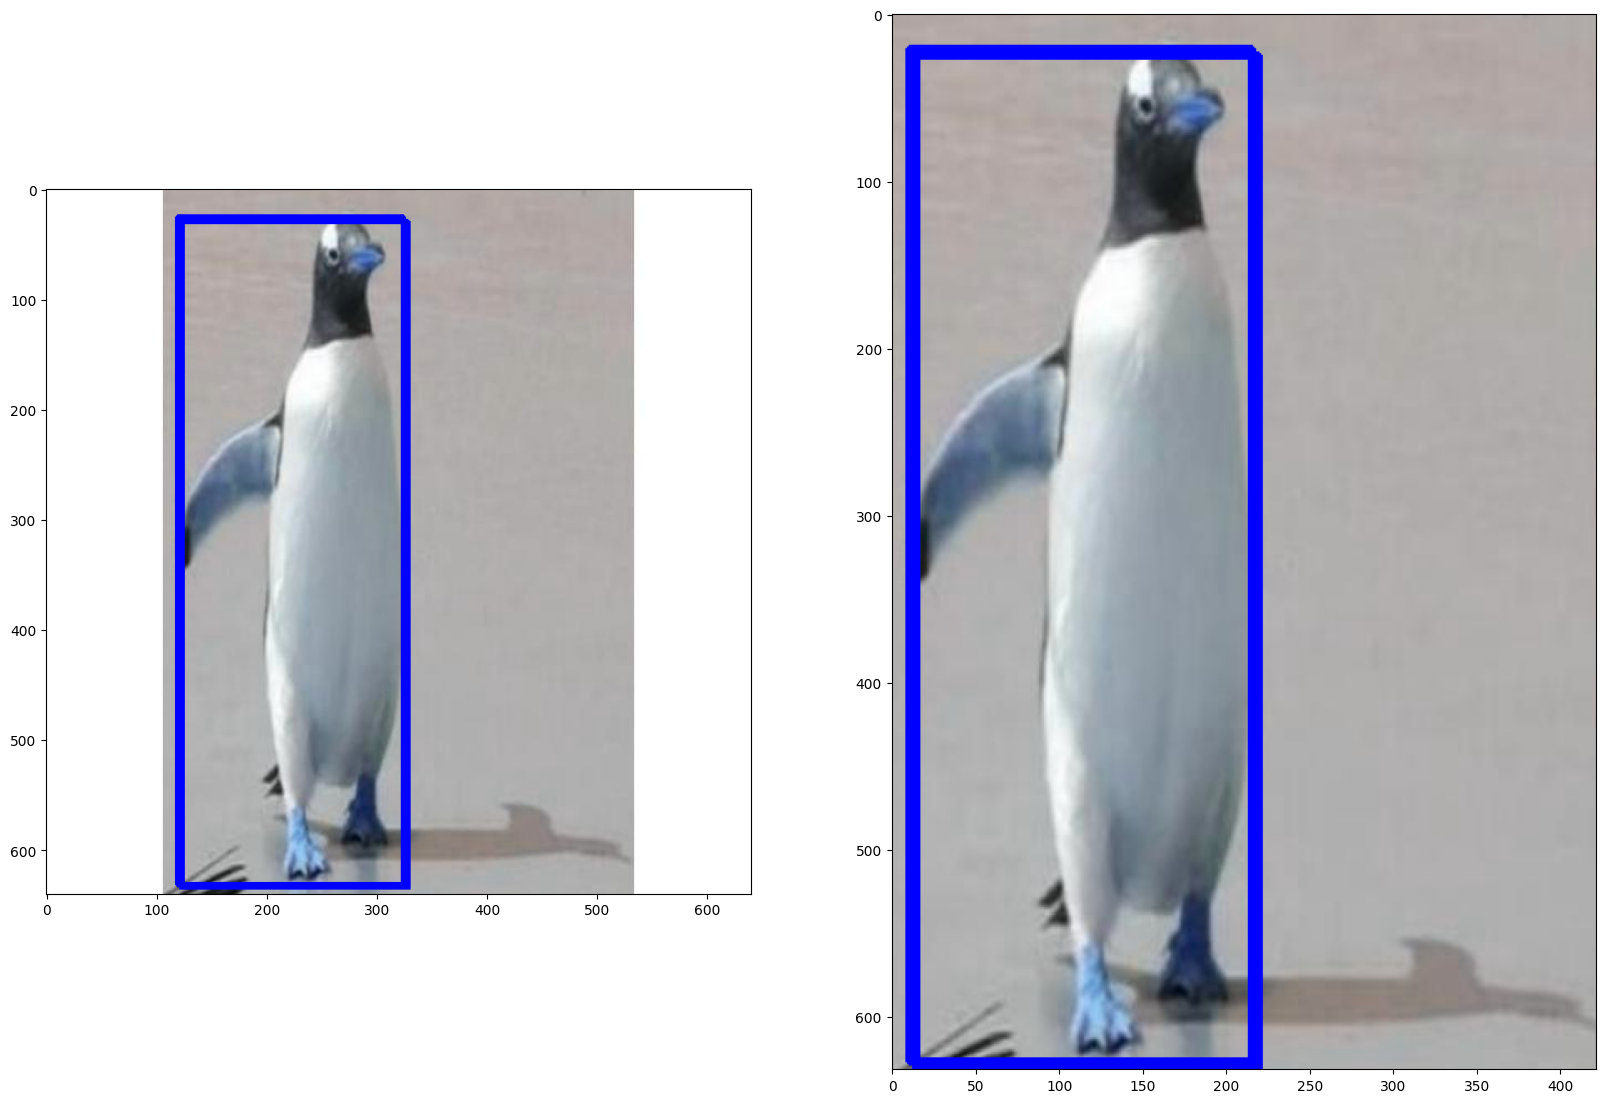

In [89]:
example_image_num = 0
example_img_path = img_path_generator(train_img_directory, example_image_num)
t, b, l, r, img = find_true_boundary_of_image(example_img_path)
annotations = annotaion_info_getter(train_image_annotation_path)
cut_img = img[t+4:b-4, l+4:r-4]
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
xmin = annotations[example_image_num]["bbox"][0]
ymin = annotations[example_image_num]["bbox"][1]
xmax = annotations[example_image_num]["bbox"][2] + xmin
ymax = annotations[example_image_num]["bbox"][3] + ymin
cut_obj_boundXmin = xmin - l
cut_obj_boundXmax = xmax - l
cut_obj_boundYmin = ymin - t
cut_obj_boundYmax = ymax - t
cv.rectangle(img, (round(xmin), round(ymin)), (round(xmax), round(ymax)), (0, 0, 255), 3)
cv.rectangle(cut_img, (round(cut_obj_boundXmin), round(cut_obj_boundYmin)), (round(cut_obj_boundXmax), round(cut_obj_boundYmax)), (0, 0, 255), 3)
ax[0].imshow(img)

ax[1].imshow(cut_img)

plt.show()

### Below is a Help function that read image, find the cutting edge boundary, recalculate the object boundary, and prepare for preprocessing.
- This help function also extracts all info from the annotation file and store into the return list.

In [90]:
def prepare_preprocessing(directory, annotation_path):
    img_list = []
    img_num = 0
    annotations = annotaion_info_getter(annotation_path)
    while True:
        new_img_path = img_path_generator(directory, img_num)
        if new_img_path is None:
            break
        classification = annotations[img_num]["category_id"]
        cut_top, cut_bottom, cut_left, cut_right, img = find_true_boundary_of_image(new_img_path)
        xmin = annotations[img_num]["bbox"][0]
        ymin = annotations[img_num]["bbox"][1]
        xmax = annotations[img_num]["bbox"][2]
        ymax = annotations[img_num]["bbox"][3]
        area = annotations[img_num]["area"]
        obj = {}
        obj["path"] = new_img_path
        obj["GraphWithoutWhiteBackgroundXmin"] = cut_left + 3
        obj["GraphWithoutWhiteBackgroundXmax"] = cut_right - 3
        obj["GraphWithoutWhiteBackgroundYmin"] = cut_top + 3
        obj["GraphWithoutWhiteBackgroundYmax"] = cut_bottom - 3
        obj["ObjBoundXmin"] = xmin
        obj["ObjBoundXmax"] = xmax + xmin
        obj["ObjBoundYmin"] = ymin
        obj["ObjBoundYmax"] = ymax + ymin
        obj["ObjArea"] = area
        obj["classification"] = classification
        img_list.append(obj)
        img_num += 1
    return img_list

In [91]:
img_info_list = prepare_preprocessing(train_img_directory, train_image_annotation_path)

### Image Blur and Edge Strength Preprocess
- We also use some image blur before extracting the feature. By doing so, we can filter the noise pixels in the images.
- We use the Gaussian Blur with adjusted kernal size to blur the image
- The binary morphology operation is also used to blur the image, and strengthen the edge.
- The parameter to do these operations is adjusted by us to have the best result in traditional method.

In [92]:
def binary_morphological_operate(img, kernal_size, is_dilate, iteration_num):
    gray_img = img
    gray_img = cv.cvtColor(gray_img, cv.COLOR_BGR2GRAY)
    kernal_size = abs(kernal_size)
    kernal = np.ones((kernal_size, kernal_size), np.uint64)
    if is_dilate:
        gray_img = cv.dilate(gray_img, kernal, iterations=iteration_num)
    else:
        gray_img = cv.erode(gray_img, kernal, iterations=iteration_num)
    result = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
    return result

def Gaussian_Blur(img, kernal):
    img = cv.GaussianBlur(img, kernal, 0, 0)
    return img

# Preprocessing Function
- The function provides multiple swith to open and close different preprocessing process.
### Feature Extraction
- We use HOG to extract the feature from the image. The HOG feature extraction works pretty good in different light conditions, and it can also focus into the local details with the cell provided.
### Resize the picture
- We also resize every picture into a 450 * 450 square picture. We doing so is because the consistency. When applying feature extraction techniques like HOG, the input image's dimensions need to be consistent for feature extraction to be meaningful.
### Provide Lambda Function for later use to calculate boundary in original image
- After applying the preprocessing steps, it's important to keep in mind that the resulting images undergo two key transformations. Initially, we cut off the two white edges either along the horizontal or vertical sides. Subsequently, the images are further resized to a 450 * 450 square shape.
- Due to these transformations, when using the preprocessed images for object detection, the final boundary we obtain might not precisely correspond to the true boundary present in the original image. This discrepancy arises because the cutting and resizing operations alter the image dimension.
- So in the end of this preprocessing function, it also returns a list of lambda functions for us to transfer the boundary we found in preprocessed image to the original image.
### Provide Feature List and True Boundary for later use
- The feature extracted from HOG, and the true boundary of the object we calculated, will be returned as two lists in this function. The True Boundary of different images will be in form [[xmin,xmax,ymin,ymax]...].  Later on, when we train our model, the feature extracted list will be XTrain, and the True Boundary list will be YTrain.
- The extracted frature from the test imges will also be used  to predict the object boundary and classification result.
### Classification List
- A list of the true result of classification extracted from annotation file is also returned. This will be later used in the classification part.

In [93]:
def preprocessing_imgs(image_information_list, take_edge_slide, take_gaussian):
    kernel_size = (3, 3)
    resized_width = 450
    resized_height = 450
    orientations = 9            # number of orientations
    pixels_per_cell = (22, 22)  # pixels in each cell
    cells_per_block = (3, 3)    # cells in each block
    feature_list = []
    train_targets = []
    i = 0
    resize_bound_back_to_original_x = []
    resize_bound_back_to_original_y = []
    classifications  = []
    preprocessed_img_list = []
    for info_obj in image_information_list:
        img_path = info_obj["path"]
        img = cv.imread(img_path)
        img = binary_morphological_operate(img,3, True, 1)
        img = binary_morphological_operate(img,2, False, 1)
        boundXmin = info_obj["ObjBoundXmin"]
        boundXmax = info_obj["ObjBoundXmax"]
        boundYmin = info_obj["ObjBoundYmin"]
        boundYmax = info_obj["ObjBoundYmax"]
        classification = info_obj["classification"]
        classifications.append(classification)
        if take_edge_slide:
            cut_x_min = info_obj["GraphWithoutWhiteBackgroundXmin"]
            cut_x_max = info_obj["GraphWithoutWhiteBackgroundXmax"]
            cut_y_min = info_obj["GraphWithoutWhiteBackgroundYmin"]
            cut_y_max = info_obj["GraphWithoutWhiteBackgroundYmax"]
            cut_img = img[cut_y_min:cut_y_max, cut_x_min:cut_x_max]
            boundXmin -= cut_x_min
            boundXmax -= cut_x_min
            boundYmin -= cut_y_min
            boundYmax -= cut_y_min
            cut_height, cut_width, _ = cut_img.shape
        else:
            cut_img = img
            cut_height, cut_width, _ = cut_img.shape
            cut_x_min = 0
            cut_x_max = cut_width
            cut_y_min = 0
            cut_y_max = cut_height
        if take_gaussian:
            blur_img = Gaussian_Blur(cut_img, kernel_size)
        else:
            blur_img = cut_img

        resized_image = cv.resize(blur_img, (resized_width, resized_height))
        preprocessed_img_list.append(resized_image)
        resized_boundXmin = max(round(boundXmin * resized_width / cut_width), 0)
        resized_boundXmax = max(round(boundXmax *  resized_width / cut_width), 0)
        resized_boundYmin = max(round(boundYmin * resized_height / cut_height), 0)
        resized_boundYmax = max(round(boundYmax * resized_height / cut_height), 0)
        resize_bound_to_actual_bound_X = lambda x, cut_width=cut_width, resized_width=resized_width, cut_x_min=cut_x_min, cut_x_max = cut_x_max: min(max(round(x * cut_width / resized_width + cut_x_min), cut_x_min), cut_x_max)
        resize_bound_to_actual_bound_Y = lambda y, cut_height=cut_height, resized_height=resized_height, cut_y_min=cut_y_min, cut_y_max = cut_y_max: min(max(round(y * cut_height / resized_height + cut_y_min), cut_y_min), cut_y_max)
        features = hog(resized_image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channel_axis= -1)
        feature_list.append(features)
        train_targets.append([resized_boundXmin, resized_boundXmax, resized_boundYmin, resized_boundYmax])
        resize_bound_back_to_original_x.append(resize_bound_to_actual_bound_X)
        resize_bound_back_to_original_y.append(resize_bound_to_actual_bound_Y)
    feature_list = np.array(feature_list)
    feature_list = feature_list.reshape(len(feature_list), -1)
    true_boundary = np.array(train_targets)
    return feature_list, true_boundary, resize_bound_back_to_original_x, resize_bound_back_to_original_y, classifications, preprocessed_img_list

In [94]:
# Get the  train information from the preprocessing function.
X_train, Y_train, _, _, train_classification, _ = preprocessing_imgs(img_info_list, True, True)

# Object Detection
### Decision Tree Regressor
- We  use the Decision Tree Regressor for object detection for some benefits:
1. It can effectively capture non-linear relationships between image features and object locations.
2. Decision trees can handle noisy data in some extent.
- The parameter of the model is adjusted to have the best performance using this model.

In [95]:
dt_classifier = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=1000,
    min_samples_split=40,
    min_samples_leaf=40,
    random_state=100)
dt_classifier.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=1000, min_samples_leaf=40, min_samples_split=40,
                      random_state=100)

In [96]:
# Get test information from the preprocessing image
test_img_info  = prepare_preprocessing(test_img_directory, test_image_annotation_path)
X_test, Y_test,test_bound_back_to_original_bound_x, test_bound_back_to_original_bound_y, test_clasification, test_preprocessed_imgs = preprocessing_imgs(test_img_info, True, True)

In [97]:
# Predict the object boundary for the test images.
Y_predicted = dt_classifier.predict(X_test)

##### A helper function to transfer the boundary we found in preprocessed image to the original image. The helper function needs to use the lambda function provided in the preprocessing function.

In [98]:
def back_to_original_bound(resized_bound_list, back_bound_function_x_list, back_bound_function_y_list):
    i = 0
    result_bound = []
    for bound in resized_bound_list:
        bound_x_min = back_bound_function_x_list[i](bound[0])
        bound_x_max = back_bound_function_x_list[i](bound[1])
        bound_y_min = back_bound_function_y_list[i](bound[2])
        bound_y_max = back_bound_function_y_list[i](bound[3])
        result_bound.append([bound_x_min, bound_x_max, bound_y_min, bound_y_max])
        i += 1
    return result_bound

In [99]:
# Get the predicted object boundary
bound_predicted_test  = back_to_original_bound(Y_predicted, test_bound_back_to_original_bound_x, test_bound_back_to_original_bound_y)
# Get the true object boundary
true_bound_test  = back_to_original_bound(Y_test, test_bound_back_to_original_bound_x, test_bound_back_to_original_bound_y)

# We will then compare the predicted boundary with the true object boundary and generate the results.

## Helper Function to generate result
- Below is the helper function to generate results. Using these helper functions, we can calculate the distance between the center of predicted object boundary and the center of true object boundary. The helper function can also calculate the IoU of the object boundary.

In [100]:
# Helper function to calculate the distance between two boundary centers.
def calculate_distance(boundary_1, boundary_2):
    box1_center_x = (boundary_1[0] + boundary_1[1]) / 2
    box1_center_y = (boundary_1[2] + boundary_1[3]) / 2

    box2_center_x = (boundary_2[0] + boundary_2[1]) / 2
    box2_center_y = (boundary_2[2] + boundary_2[3]) / 2

    # calculate distance between two boundaries
    d = np.sqrt((box1_center_x - box2_center_x)**2 + (box1_center_y - box2_center_y)**2)

    return d

# Calculate the IoU of two object boundaries.
def calculate_intersection_over_union(coordinate1, coordinate2):
    intersection_x1 = max(coordinate1[0], coordinate2[0])
    intersection_y1 = max(coordinate1[2], coordinate2[2])
    intersection_x2 = min(coordinate1[1], coordinate2[1])
    intersection_y2 = min(coordinate1[3], coordinate2[3])
    Intersection = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)
    coordinate1_obj_area = (coordinate1[1] - coordinate1[0] + 1) * (coordinate1[3] - coordinate1[2] + 1)
    coordinate2_obj_area = (coordinate2[1] - coordinate2[0] + 1) * (coordinate2[3] - coordinate2[2] + 1)
    Union = coordinate1_obj_area + coordinate2_obj_area - Intersection
    IoU = Intersection / Union
    return IoU

In [101]:
# Calculate Object Boundary Prediction Result

distances = []
ious = []
for true_box, pred_box in zip(true_bound_test, bound_predicted_test):
    distance = calculate_distance(true_box, pred_box)
    iou = calculate_intersection_over_union(true_box, pred_box)
    distances.append(distance)
    ious.append(iou)

In [102]:
mean_distance = np.mean(distances)
std_distance = np.std(distances)
mean_iou = np.mean(ious)
std_iou = np.std(ious)

# Object Boundary Prediction Result
- Below is the object detection result using decision tree regressor.

In [103]:
print(f"Mean Distance: {mean_distance}")
print(f"Standard Deviation of Distance: {std_distance}")
print(f"Mean IoU: {mean_iou}")
print(f"Standard Deviation of IoU: {std_iou}")

Mean Distance: 74.43743056423975
Standard Deviation of Distance: 41.23121845687355
Mean IoU: 0.42658471234324996
Standard Deviation of IoU: 0.1549740727864535


# Visualization of Object Detection Result
- The object boundary detected will be drawn into the original image, and the program will store all these image into the "visualization_object_detection_directory" you set at the beginning of this notebook. After this step, you can visualize the object detection result in the target directory.

In [104]:
def save_predicted_boundaries_img(image, bounds, save_directory, image_name):
    xmin = bounds[0]
    xmax = bounds[1]
    ymin = bounds[2]
    ymax = bounds[3]
    # Draw Rectangle
    cv.rectangle(image, (round(xmin), round(ymin)), (round(xmax), round(ymax)), (0, 0, 255), 2)

    # Save image to the target directory
    save_path = os.path.join(save_directory, image_name)
    cv.imwrite(save_path, image)

save_dire = visualization_object_detection_directory
if not os.path.exists(save_dire):
    os.makedirs(save_dire)

for info_obj, pred_bound in zip(test_img_info,  bound_predicted_test):
    img_path = info_obj["path"]
    img = cv.imread(img_path)
    img_name = os.path.splitext(os.path.basename(img_path))[0] + "_boundary.jpg"
    save_predicted_boundaries_img(img, pred_bound, save_dire, img_name)

In [105]:
predicted_object_only_image_features = []
for preprocessed_img, bounds in zip(test_preprocessed_imgs, bound_predicted_test):
    resized_x = 450
    resized_y = 450
    xmin = bounds[0]
    xmax = bounds[1]
    ymin = bounds[2]
    ymax = bounds[3]
    img = preprocessed_img[ymin:ymax, xmin:xmax]
    img = cv.resize(img, (resized_x, resized_y))
    orientations = 9
    pixels_per_cell = (22, 22)  # pixels in each cell
    cells_per_block = (3, 3)    # cells in each block
    features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channel_axis= -1)
    predicted_object_only_image_features.append(features)
predicted_object_only_image_features = np.array(predicted_object_only_image_features)
predicted_object_only_image_features = predicted_object_only_image_features.reshape(len(predicted_object_only_image_features), -1)
print(len(predicted_object_only_image_features))

72


## Classification Part
- We use SGD classifier to do the classification work as traditional method.

In [106]:
# Get the trainX and trainY. The trainX is the feature list returned by preprocessing function, whereas the trainY is the classification result returned by preprocessing function.
classification_train_x = X_train
classification_train_y = train_classification


use_predicted_obj_boundary_feature = False
if use_predicted_obj_boundary_feature:
    test_x = predicted_object_only_image_features
else:
    test_x = X_test
test_actual_y = test_clasification

## Train the SGD classifier to classify images.

In [112]:
SGD = SGDClassifier(max_iter = 2000)
SGD.fit(classification_train_x, classification_train_y)
sdg_predict = SGD.predict(test_x)

# Classification Result

In [113]:
accu = metrics.accuracy_score(test_actual_y, sdg_predict)
prec = metrics.precision_score(test_actual_y, sdg_predict, average = "macro")
reca = metrics.recall_score(test_actual_y, sdg_predict, average = "macro")
f1 = metrics.f1_score(test_actual_y, sdg_predict, average = "macro")
print("The Accuracy Score: ", accu)
print("The Precision score: ", prec)
print("The Recall Score: ", reca)
print("The f1 score: ", f1)

The Accuracy Score:  0.8055555555555556
The Precision score:  0.809375
The Recall Score:  0.8055555555555556
The f1 score:  0.804953560371517


# Classification Visualization
- Store all classification labels into the visualiation directory.
- 1 for penguin, 2 for turtle

In [114]:
save_dire = visualization_object_classification_directory
if not os.path.exists(save_dire):
    os.makedirs(save_dire)
for info_obj, classification in zip(test_img_info,  sdg_predict):
    img_path = info_obj["path"]
    label_file_path = os.path.splitext(os.path.basename(img_path))[0] + "_predict_label.txt"
    save_path = os.path.join(save_dire, label_file_path)
    with open(save_path, 'w') as file:
        file.write(str(classification))